In [108]:
import pandas as pd
import Levenshtein as lev
from scipy.spatial.distance import pdist, squareform
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import networkx as nx
import gravis as gv

# Note you will need to download muscle into the usr/bin and rename it simply as muscle
import biotite.sequence as seq
import biotite.application.muscle as muscle
import biotite.sequence.graphics as graphics

from scipy.stats import mode

import itertools

# Set 1

In [109]:
os.chdir('/home/jupyter') #/data')

In [110]:
pool1 = pd.read_csv("data/ILT4-pool1-10062022/filtered_contig_annotations.csv")
#pool1 = pd.read_csv("ILT4-pool1-10062022/airr_rearrangement.tsv", sep="\t")
#pool1_filtered_barcodes = pd.read_csv("ILT4-pool1-10062022/filtered_contig_annotations.csv", usecols=['barcode'])['barcode'].to_list()
#pool1 = pool1[pool1.cell_id.isin(pool1_filtered_barcodes)]
pool1['sample_num'] = "pool_1"

pool2 = pd.read_csv("data/ILT4-pool2-10062022/filtered_contig_annotations.csv")
#pool2 = pd.read_csv("ILT4-pool2-10062022/airr_rearrangement.tsv", sep="\t")
#pool2_filtered_barcodes = pd.read_csv("ILT4-pool2-10062022/filtered_contig_annotations.csv", usecols=['barcode'])['barcode'].to_list()
#pool2 = pool2[pool2.cell_id.isin(pool2_filtered_barcodes)]
pool2['sample_num'] = "pool_2"

config = pd.concat([pool1, pool2], axis=0).reset_index(drop=True)
config

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,...,cdr3,cdr3_nt,fwr4,fwr4_nt,reads,umis,raw_clonotype_id,raw_consensus_id,exact_subclonotype_id,sample_num
0,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_1,True,516,IGK,IGKV8-24,NaN,IGKJ2,IGKC,...,CQQHYSTPYTF,TGTCAGCAACATTATAGCACTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,2552,11,clonotype1,clonotype1_consensus_2,1,pool_1
1,AAACCTGAGCTCTCGG-1,True,AAACCTGAGCTCTCGG-1_contig_2,True,568,IGH,IGHV1-53,NaN,IGHJ4,IGHG1,...,CARYYKYDYYAMDFW,TGTGCAAGATACTATAAATACGACTACTATGCTATGGACTTCTGG,GQGTSVTVSS,GGTCAAGGAACCTCAGTCACCGTCTCCTCAG,718,1,clonotype1,clonotype1_consensus_1,1,pool_1
2,AAACCTGAGTGCCATT-1,True,AAACCTGAGTGCCATT-1_contig_1,True,481,IGK,IGKV6-32,NaN,IGKJ2,IGKC,...,CQQDYSSLTF,TGTCAGCAGGATTATAGCTCTCTCACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,154,14,clonotype321,clonotype321_consensus_1,1,pool_1
3,AAACCTGCAAGCTGAG-1,True,AAACCTGCAAGCTGAG-1_contig_1,True,514,IGK,IGKV8-24,NaN,IGKJ2,IGKC,...,CQQHYSTPYTF,TGTCAGCAACATTATAGCACTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,508,5,clonotype9,clonotype9_consensus_1,1,pool_1
4,AAACCTGCACATTCGA-1,True,AAACCTGCACATTCGA-1_contig_1,True,522,IGK,IGKV1-117,NaN,IGKJ2,IGKC,...,CFQGSHVPYTF,TGCTTTCAAGGTTCACATGTTCCGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,234,15,clonotype5,clonotype5_consensus_1,1,pool_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16779,TTTGTCATCACCCGAG-1,True,TTTGTCATCACCCGAG-1_contig_2,True,651,IGH,IGHV2-9,NaN,IGHJ2,IGHM,...,CARDLYDYYFDYW,TGTGCCAGAGATCTCTATGATTACTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,2758,15,clonotype1362,clonotype1362_consensus_1,1,pool_2
16780,TTTGTCATCACGATGT-1,True,TTTGTCATCACGATGT-1_contig_1,True,523,IGK,IGKV3-12,NaN,IGKJ1,IGKC,...,CQHSRELPRTF,TGTCAGCACAGTAGGGAGCTTCCTCGGACGTTC,GGGTKLEIK,GGTGGAGGCACCAAGCTGGAAATCAAAC,836,15,clonotype76,clonotype76_consensus_2,2,pool_2
16781,TTTGTCATCGCCAAAT-1,True,TTTGTCATCGCCAAAT-1_contig_1,True,712,IGH,IGHV5-9,NaN,IGHJ2,IGHD,...,CARQGLYGKGRYFDYW,TGTGCAAGACAGGGACTATATGGTAAAGGGAGGTACTTTGACTACTGG,GQGTTLTVSS,GGCCAAGGCACCACTCTCACAGTCTCCTCAG,284,2,clonotype2381,clonotype2381_consensus_1,1,pool_2
16782,TTTGTCATCGCCAAAT-1,True,TTTGTCATCGCCAAAT-1_contig_2,True,497,IGK,IGKV19-93,NaN,IGKJ2,IGKC,...,CLQYDNLYTF,TGTCTACAGTATGATAATCTGTACACGTTC,GGGTKLEIK,GGAGGGGGGACCAAGCTGGAAATAAAAC,912,10,clonotype2381,clonotype2381_consensus_2,1,pool_2


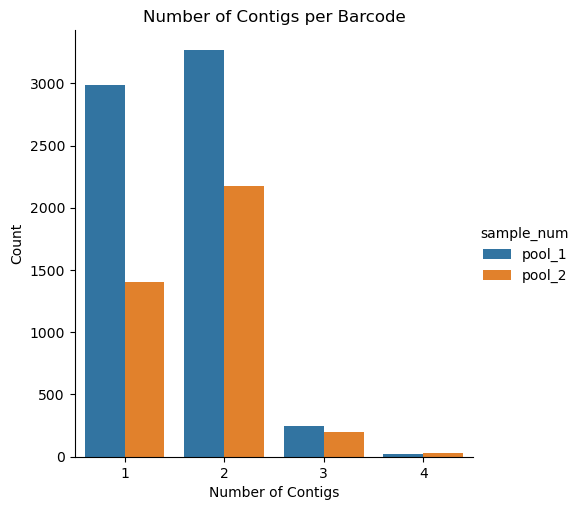

In [111]:
barcode_counts =  config.groupby(['sample_num', 'barcode']).count()[["is_cell"]].reset_index()

num_of_contigs_per_barcode = barcode_counts.groupby(['sample_num', "is_cell"]).count().reset_index()
num_of_contigs_per_barcode = num_of_contigs_per_barcode.rename(columns={"is_cell":"num_contigs", "barcode":"count"})

sns.catplot(data=num_of_contigs_per_barcode,
           x="num_contigs", y="count", hue="sample_num",
           kind="bar").set(title="Number of Contigs per Barcode", 
                           xlabel="Number of Contigs",
                           ylabel="Count");

In [113]:
barcode_2_chains_only = barcode_counts[barcode_counts['is_cell'] == 2]['barcode']

config_2_chains = config[config['barcode'].isin(barcode_2_chains_only)]

config_h = config_2_chains[config_2_chains['chain'] == 'IGH'].set_index('barcode')
config_l = config_2_chains[config_2_chains['chain'] != 'IGH'].set_index('barcode')

paired_config = config_h.merge(config_l, on='barcode')[['chain_x', 'chain_y', 'sample_num_x']].reset_index(drop=True)

stacked_paired_config = pd.concat([paired_config[['chain_x', 'sample_num_x']].rename(columns={'chain_x': 'chain'}),
                                   paired_config[['chain_y', 'sample_num_x']].rename(columns={'chain_y': 'chain'})], axis=0).rename(columns={'sample_num_x': 'sample_num'})
stacked_paired_config

,chain,sample_num
0,IGH,pool_1
1,IGH,pool_1
2,IGH,pool_1
3,IGH,pool_1
4,IGH,pool_2
...,...,...
8174,IGK,pool_2
8175,IGK,pool_2
8176,IGK,pool_2
8177,IGK,pool_2


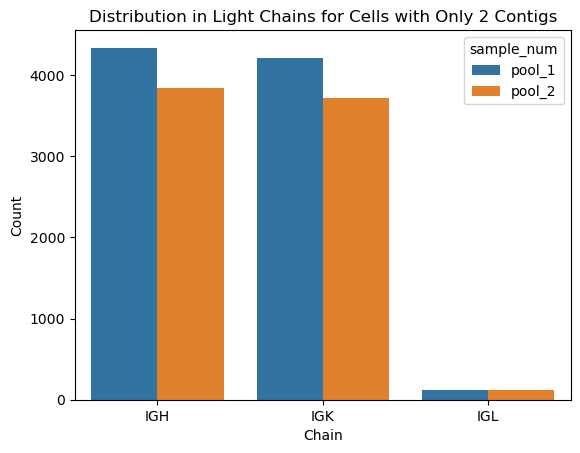

In [114]:
sns.countplot(data=stacked_paired_config, x='chain', hue="sample_num").set(
    title="Distribution in Light Chains for Cells with Only 2 Contigs",
    xlabel="Chain", ylabel="Count");

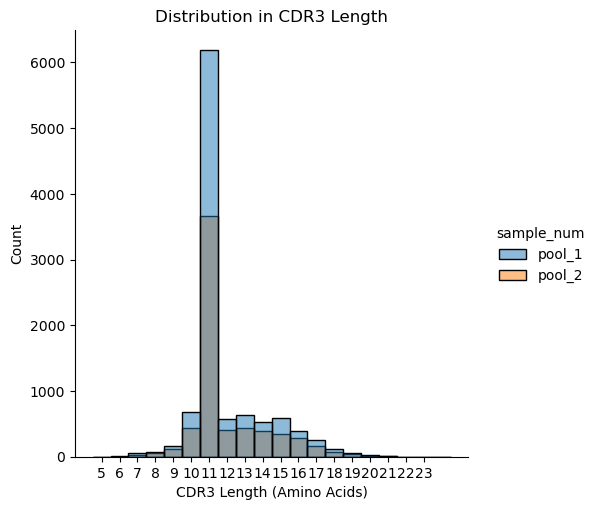

In [115]:
config['cdr3_len'] = pd.Categorical(config['cdr3'].apply(len))

sns.displot(data=config,
           x="cdr3_len", hue="sample_num", bins=19).set(title="Distribution in CDR3 Length",
                            xlabel="CDR3 Length (Amino Acids)",
                            ylabel="Count")

plt.xticks(np.arange(min(config['cdr3_len']), max(config['cdr3_len']), 1));

## Filter Configs

Decided to only use all cells with only Heavy CRD3, but can only have one or two contigs associated per barcode

In [132]:
# Select the cells that only have 2 productive sequences
#barcode_w_pair_list = barcode_counts[barcode_counts.is_cell == 2]['barcode'].tolist()
#filtered_config = config[config.barcode.isin(barcode_w_pair_list)]
#filtered_config

In [131]:
# Create a dataframe where one row corresponds to one cell with two sets of chain sequence
#heavy_chains = filtered_config[filtered_config['chain'] == "IGH"].set_index('barcode')[['cdr1', 'cdr2', 'cdr3']]
#heavy_chains = heavy_chains.rename(columns={"cdr1": "h_cdr1", "cdr2": "h_cdr2", "cdr3": "h_cdr3"})

#light_chains = filtered_config[filtered_config['chain'] != "IGH"].set_index('barcode')[['cdr1', 'cdr2', 'cdr3']]
#light_chains = light_chains.rename(columns={"cdr1": "l_cdr1", "cdr2": "l_cdr2", "cdr3": "l_cdr3"}) 

# Do an inner join to remove any chance of keeping cells with double heavy chain or double light chain
#chains = heavy_chains.merge(light_chains, left_index=True, right_index=True, how='inner').reset_index()
#chains

In [123]:
barcode_cells_for_analysis = barcode_counts[barcode_counts['is_cell'] < 3]['barcode']

chains = config[config['barcode'].isin(barcode_cells_for_analysis)]
chains = chains[chains['chain'] == 'IGH']

chains = chains[['barcode', 'cdr3']].rename(columns={'cdr3': 'h_cdr3'})

chains

,barcode,h_cdr3
1,AAACCTGAGCTCTCGG-1,CARYYKYDYYAMDFW
11,AAACCTGCAGACACTT-1,CAWREPYYYGSRDDYW
13,AAACCTGCATCAGTAC-1,CAKEGYGNYESAMDYW
15,AAACCTGGTCTCCCTA-1,CARIRRTEYYAMDYW
16,AAACCTGGTGTTTGTG-1,CAIYYDYAWFAYW
...,...,...
16767,TTTGTCACAACTGCGC-1,CARSYYRYAFAYW
16770,TTTGTCACACTTACGA-1,CARPIYYYGSSPAWFAYW
16774,TTTGTCACATGGTAGG-1,CARESDGYYSWFAYW
16779,TTTGTCATCACCCGAG-1,CARDLYDYYFDYW


## Generate Distance Matricies

In [124]:
def distance_matrix(cdr):
    # Function that accepts a CDR column and ouputs a levenshtein distance matrix
    # Note: this process is computationally intensive
    
    # Prepare 2 dimensional array M x N (M entries (len cdr3_sequences) with N dimensions (1)) 
    transformed_strings = np.array(cdr).reshape(-1,1)
    
    # Calculate distance matrix using the Levenshtein distance function
    distance_matrix = pdist(transformed_strings, lambda x,y: lev.distance(x[0],y[0]))
    
    # Square distance matrix
    cdr_matrix = squareform(distance_matrix).astype(np.int64)
    
    return cdr_matrix

# Calculate all six distance matricies
#h_cdr1_mtx = distance_matrix(chains['h_cdr1'])
#h_cdr2_mtx = distance_matrix(chains['h_cdr2'])
h_cdr3_mtx = distance_matrix(chains['h_cdr3'])
#l_cdr1_mtx = distance_matrix(chains['l_cdr1'])
#l_cdr2_mtx = distance_matrix(chains['l_cdr2'])
#l_cdr3_mtx = distance_matrix(chains['l_cdr3'])

In [10]:
def upper_right_no_diag(mtx):
    # Function that gets all the numbers to the upper right of the diagonal, without including the diagonal
    # Return a list of the numbers
    
    cdr_len = mtx.shape[0]
    distance_distribution = []

    for row in np.arange(0, cdr_len-1):
        for col in np.arange(row+1, cdr_len):
            distance_distribution += [mtx[row, col]]
            
    return distance_distribution

In [11]:
# Get the LD distance
#h_cdr1_dist = upper_right_no_diag(h_cdr1_mtx)
#h_cdr2_dist = upper_right_no_diag(h_cdr2_mtx)
#h_cdr3_dist = upper_right_no_diag(h_cdr3_mtx)
#l_cdr1_dist = upper_right_no_diag(l_cdr1_mtx)
#l_cdr2_dist = upper_right_no_diag(l_cdr2_mtx)
#l_cdr3_dist = upper_right_no_diag(l_cdr3_mtx)

In [12]:
def plot_upper_right_no_diag(cdr_dist, chain_str, cdr_str, tick_range):
    
    mean = round(np.mean(cdr_dist), 2)
    sd = round(np.std(cdr_dist), 2)
    
    title=chain_str+ " Chain - "+cdr_str+": mean="+str(mean)+", sd="+str(sd)
    
    sns.countplot(data=cdr_ld_dist, x="h_cdr3_ld").set(title=title, xlabel="Levenshtein Distance (Amino Acids)", ylabel="Count", xticks=tick_range)

In [13]:
plot_upper_right_no_diag(l_cdr3_dist, "Light", "CDR3", range(0, 21))

NameError: name 'l_cdr3_dist' is not defined

## Examine Possible Distance Weights

In [14]:
def meta_distance_matrix(weights=[1, 1, 1, 1, 1, 1]):
    return h_cdr1_mtx*weights[0] + h_cdr2_mtx*weights[1] + h_cdr3_mtx*weights[2] + l_cdr1_mtx*weights[3] + l_cdr2_mtx*weights[4] + l_cdr3_mtx*weights[5]

In [125]:
#meta_mtx = meta_distance_matrix()
meta_mtx = h_cdr3_mtx

In [126]:
# Identify the cutoff point on whether there should be an edge between two nodes 
# Based on https://www.frontiersin.org/articles/10.3389/fimmu.2018.00224/full#h3, 
# the standard is one amino acid difference
cutoff_point = 2

# Generate binary boolean distance matrix
boolean_filter = meta_mtx < cutoff_point
boolean_filter = boolean_filter.astype(int)

G = nx.Graph()

# Add the nodes per unique sequence
G.add_nodes_from(np.arange(meta_mtx.shape[0]))

# Add the edges
# Take the upper right triangular matrix w/out diagnonal
# https://people.revoledu.com/kardi/tutorial/VB/tips/Symmetric-Matrix.html
for row in np.arange(0, meta_mtx.shape[0]-1):
    for col in np.arange(row+1, meta_mtx.shape[0]):
        if boolean_filter[row, col] == 1:
            G.add_weighted_edges_from([(row, col, 1)])

# Set node weights based on number of edges
#node_degree = [G.degree(x) for x in np.arange(len(cdr3_sequences))]
#for i in np.arange(len(cdr3_sequences)):
#    G.nodes[i]['size'] = node_degree[i]

# Node degree - number of edges per node
# Calculate this before removing the nodes with no edges
#degree_sequence = [d for n, d in G.degree()]

# Remove nodes with no edges
#G.remove_nodes_from(list(nx.isolates(G)))

# To visualize graph (note: computationally intensive)
#gv.d3(G, edge_size_data_source='weight', use_node_size_normalization=True)

clusters = sorted(nx.connected_components(G), key=len, reverse=True)
top10_clusters = [list(x) for x in clusters[:10]]

In [134]:
#gv.d3(G, edge_size_data_source='weight', use_node_size_normalization=True)

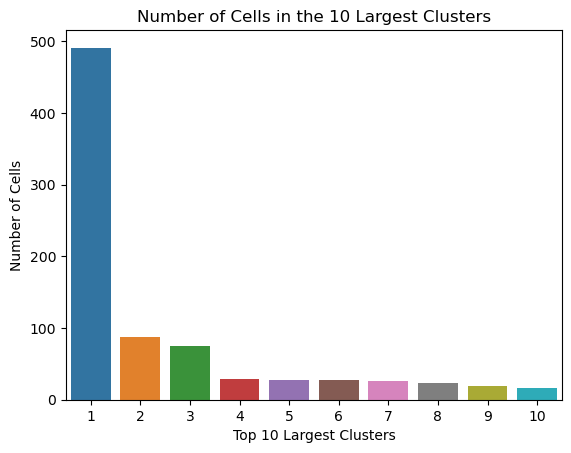

In [136]:
ax = sns.barplot(x=np.arange(1, 11), y=[len(x) for x in top10_clusters])

plt.xlabel("Top 10 Largest Clusters")
plt.ylabel("Number of Cells")
plt.title("Number of Cells in the 10 Largest Clusters");

In [148]:
degree_centrality = pd.DataFrame()
degree_centrality['Cell Number'] = list(nx.degree_centrality(G).keys())

# Use nx.degree_centrality(G) to get the number of edges per node
degree_centrality['degree_centrality_norm'] = list(nx.degree_centrality(G).values())
degree_centrality['degree_centrality_norm'] = np.round(degree_centrality['degree_centrality_norm']*chains.shape[0], 1)
degree_centrality = degree_centrality.rename(columns={"degree_centrality_norm": "Number of Edges"})

# Add sequence data
degree_centrality = pd.concat([degree_centrality, chains.reset_index(drop=True)], axis=1)

# Label the cells in the top clusters
def find_cluster(cell_num):
    for i in range(len(top10_clusters)):
        if int(cell_num) in top10_clusters[i]:
            return i+1
    #return None

degree_centrality['top_clusters'] = degree_centrality["Cell Number"].apply(find_cluster)

degree_centrality

,Cell Number,Number of Edges,barcode,h_cdr3,top_clusters
0,0,87.0,AAACCTGAGCTCTCGG-1,CARYYKYDYYAMDFW,2.0
1,1,1.0,AAACCTGCAGACACTT-1,CAWREPYYYGSRDDYW,NaN
2,2,0.0,AAACCTGCATCAGTAC-1,CAKEGYGNYESAMDYW,NaN
3,3,0.0,AAACCTGGTCTCCCTA-1,CARIRRTEYYAMDYW,NaN
4,4,1.0,AAACCTGGTGTTTGTG-1,CAIYYDYAWFAYW,NaN
...,...,...,...,...,...
5718,5718,0.0,TTTGTCACAACTGCGC-1,CARSYYRYAFAYW,NaN
5719,5719,0.0,TTTGTCACACTTACGA-1,CARPIYYYGSSPAWFAYW,NaN
5720,5720,0.0,TTTGTCACATGGTAGG-1,CARESDGYYSWFAYW,NaN
5721,5721,1.0,TTTGTCATCACCCGAG-1,CARDLYDYYFDYW,NaN


In [157]:
top_cluster = degree_centrality[degree_centrality['top_clusters'] == 1]
top_cluster['degree_centrality_norm'] = top_cluster['Number of Edges']/top_cluster.shape[0]
top_cluster = top_cluster.sort_values('degree_centrality_norm', ascending=False)
top_cluster

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cell Number,Number of Edges,barcode,h_cdr3,top_clusters,degree_centrality_norm
5082,5082,34.0,GTCTCGTTCGAGAGCA-1,CARGAMDYW,1.0,0.069246
1713,1713,34.0,CTTAACTCACTGCCAG-1,CARGAMDYW,1.0,0.069246
2499,2499,34.0,GTCGTAACACCTCGTT-1,CARGAMDYW,1.0,0.069246
777,777,34.0,CAAGAAAGTCATTAGC-1,CARGAMDYW,1.0,0.069246
2313,2313,34.0,GGCTGGTTCACTCCTG-1,CARGAMDYW,1.0,0.069246
...,...,...,...,...,...,...
1274,1274,1.0,CGAGCCACACGCTTTC-1,CARVRPFAYW,1.0,0.002037
1343,1343,1.0,CGCTTCAGTTATCGGT-1,CARWDYGYAMDYW,1.0,0.002037
1354,1354,1.0,CGGACACGTTGGGACA-1,CASSRYYFDYW,1.0,0.002037
2829,2829,1.0,TCAGGATAGACTAGAT-1,CARDKGAMDYW,1.0,0.002037


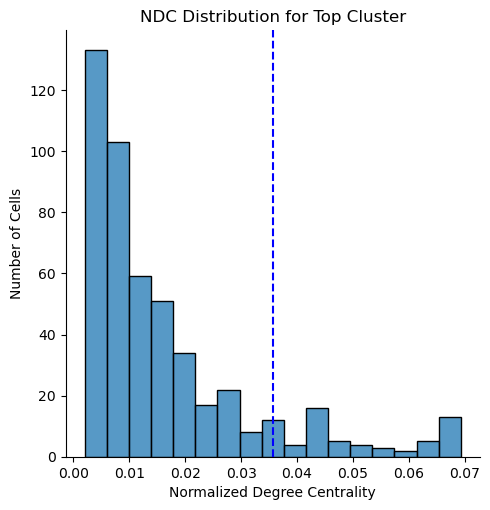

In [152]:
sns.displot(data=top_cluster, x='degree_centrality_norm')

plt.title("NDC Distribution for Top Cluster")
plt.xlabel("Normalized Degree Centrality")
plt.ylabel("Number of Cells")

midrange = (np.max(top_cluster['degree_centrality_norm']) + np.min(top_cluster['degree_centrality_norm']))/2

plt.axvline(midrange, color='blue', linestyle='--');

In [158]:
second_cluster = degree_centrality[degree_centrality['top_clusters'] == 2]
second_cluster['degree_centrality_norm'] = second_cluster['Number of Edges']/second_cluster.shape[0]
second_cluster = second_cluster.sort_values('degree_centrality_norm', ascending=False)

second_cluster

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cell Number,Number of Edges,barcode,h_cdr3,top_clusters,degree_centrality_norm
0,0,87.0,AAACCTGAGCTCTCGG-1,CARYYKYDYYAMDFW,2.0,0.988636
8,8,87.0,AAACGGGCACGAAAGC-1,CARYYKYDYYAMDFW,2.0,0.988636
2581,2581,87.0,GTTACAGTCGGATGTT-1,CARYYKYDYYAMDFW,2.0,0.988636
2537,2537,87.0,GTGCGGTCACATCTTT-1,CARYYKYDYYAMDFW,2.0,0.988636
2524,2524,87.0,GTGAAGGTCCCTCAGT-1,CARYYKYDYYAMDFW,2.0,0.988636
...,...,...,...,...,...,...
1056,1056,87.0,CCACGGAGTCAAACTC-1,CARYYKYDYYAMDFW,2.0,0.988636
1045,1045,87.0,CCACCTACAATAGAGT-1,CARYYKYDYYAMDFW,2.0,0.988636
993,993,87.0,CATCGAATCACTCCTG-1,CARYYKYDYYAMDFW,2.0,0.988636
982,982,87.0,CATCCACGTGACCAAG-1,CARYYKYDYYAMDFW,2.0,0.988636


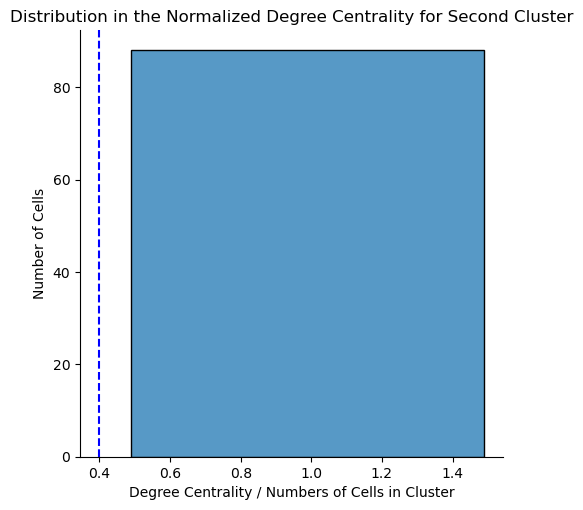

In [159]:
sns.displot(data=second_cluster, x='degree_centrality_norm')

plt.title("Distribution in the Normalized Degree Centrality for Second Cluster")
plt.xlabel("Degree Centrality / Numbers of Cells in Cluster")
plt.ylabel("Number of Cells")

plt.axvline(0.4, color='blue', linestyle='--');

In [161]:
third_cluster = degree_centrality[degree_centrality['top_clusters'] == 3]
third_cluster['degree_centrality_norm'] = third_cluster['Number of Edges']/third_cluster.shape[0]
third_cluster = third_cluster.sort_values('degree_centrality_norm', ascending=False)

third_cluster

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Cell Number,Number of Edges,barcode,h_cdr3,top_clusters,degree_centrality_norm
3423,3423,36.0,AACCGCGGTCTGCGGT-1,CMRYDGNYWYFDVW,3.0,0.480000
3357,3357,31.0,TTTCCTCCACCACCAG-1,CMRYDGYYWYFDVW,3.0,0.413333
2253,2253,31.0,GGAGCAACAACTGCTA-1,CMRYDGYYWYFDVW,3.0,0.413333
3370,3370,31.0,TTTCCTCTCTTCCTTC-1,CMRYDGYYWYFDVW,3.0,0.413333
1738,1738,31.0,CTTGGCTAGGCTCAGA-1,CMRYDGYYWYFDVW,3.0,0.413333
...,...,...,...,...,...,...
1198,1198,9.0,CCTTCCCAGGACGAAA-1,CIRYGSSYWYFDVW,3.0,0.120000
577,577,9.0,AGTGAGGTCCAGTAGT-1,CIRYGSSYWYFDVW,3.0,0.120000
4212,4212,9.0,CGAATGTGTAGCTGCC-1,CMKYGSSWYFDVW,3.0,0.120000
65,65,6.0,AACTCAGCAAAGTGCG-1,CMRYGGYWYFDVW,3.0,0.080000


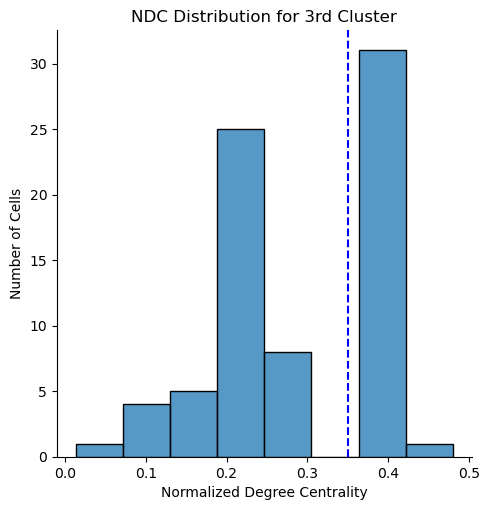

In [164]:
sns.displot(data=third_cluster, x='degree_centrality_norm')

plt.title("NDC Distribution for 3rd Cluster")
plt.xlabel("Normalized Degree Centrality")
plt.ylabel("Number of Cells")

plt.axvline(0.35, color='blue', linestyle='--');

## Consensus Analysis

In [165]:
def cluster_consensus_sequence(cluster_df, most_common_aa_cutoff = 75, num_possible_aa = 2):
    # Input:
    ## Cluster sequence dataframe
    ## Most common aa cutoff - If an amino acid at a position is x% or higher, it will always be that amino acid at that position
    ## Number of possible amino acids - selects the n number of possible amino acids per position, in highest to lowest frequency
    
    # Output:
    ## Consensus sequences per CDR region
    ## Percent frequency of each amino acid per position, useful for visualization purposes
    
    cluster_consensus_sequence_results = {}
    
    percentage_position_matrix_list = {}
    
    aa_options = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'U']
    
    cdr_column_names = cluster_df.columns[cluster_df.columns.str.contains("cdr")].to_list()
    
    for cdr_column_name in cdr_column_names:
        
        # If there is only one unique cdr sequence, then just add it to the results output
        if len(cluster_df[cdr_column_name].unique()) == 1:
            cluster_consensus_sequence_results[cdr_column_name] = [[*cluster_df[cdr_column_name].unique()[0]]]
            
        # If there is more than one, conduct multiple sequencing alignment (MSA)
        else:
            # Convert text to ProteinSequence data type from biotite
            seq_to_align = [seq.ProteinSequence(cdr_sequence) for cdr_sequence in cluster_df[cdr_column_name]]
            
            # Conduct MSA
            biotite_sub_matrix = seq.align.SubstitutionMatrix.std_protein_matrix()
            alignment, order, tree, distances = seq.align.align_multiple(seq_to_align, biotite_sub_matrix)
            
            # Extract the aligned sequences, convert None to "-"
            alignment_mtx = np.array(seq.align.get_symbols(alignment))
            alignment_mtx[alignment_mtx == None] = "-"
            
            # Create a percentage position matrix where for each amino acid position, there is a percentage frequency for all amino acids
            raw_data = {}

            for aa in aa_options:
                raw_data[aa] = list(np.sum(alignment_mtx == aa, axis=0)/alignment_mtx.shape[0]*100)
                
            # Save results for visualizing percentage position if desired
            percentage_position_matrix_list[cdr_column_name] = raw_data
                
            # Generate the consensus sequences based on percent_cutoff and num_possible_aa
            percent_position_matrix = pd.DataFrame(raw_data, columns=raw_data.keys())
            
            # Create a list where every sublist is one position and has num_possible_aa number of amino acids at that position for consensus generation
            common_aa_per_position = []
            
            for position_idx in np.arange(percent_position_matrix.shape[0]):
                
                position = percent_position_matrix.iloc[position_idx]
                
                # If a amino acid occurs most_common_aa_cutoff% at a position, it is always that amino acid
                if len(position[position >= most_common_aa_cutoff]) == 1:
                    common_aa = position[position >= most_common_aa_cutoff].index.to_list()
                    
                # If the position is more diverse, select the top num_possible_aa
                else:
                    common_aa = position.sort_values(ascending=False)[:num_possible_aa].index.to_list()
    
                common_aa_per_position += [common_aa]
    
            # Generate all the possible consensus sequence combinations 
            cdr_consensus_sequences = [list(x) for x in itertools.product(*common_aa_per_position)]
        
            cluster_consensus_sequence_results[cdr_column_name] = cdr_consensus_sequences
        
    return cluster_consensus_sequence_results, percentage_position_matrix_list

In [262]:
top_cluster_consensus, top_cluster_pp = cluster_consensus_sequence(top_cluster[top_cluster['degree_centrality_norm'] > midrange], most_common_aa_cutoff = 75, num_possible_aa = 3)

top_second_cluster_consensus, top_second_cluster_pp = cluster_consensus_sequence(second_cluster, most_common_aa_cutoff = 75, num_possible_aa = 3)

top_third_cluster_consensus, top_third_cluster_pp = cluster_consensus_sequence(third_cluster, most_common_aa_cutoff = 75, num_possible_aa = 3)

In [190]:
def visualize_position_frequency_matrix_cdr3(percentage_position_matrix_list, title):
    
    percent_position_matrix = pd.DataFrame(percentage_position_matrix_list['h_cdr3'])
    print(percent_position_matrix.shape)
    
    # Get the most common amino acid in each position
    aligned_sequence_most_frequent_char = percent_position_matrix.idxmax(axis="columns")
    
    # Visualize the stacked percentage bar plot

    barWidth = 0.85
    aa_position = np.arange(percent_position_matrix.shape[0])

    cm = plt.get_cmap('gist_rainbow')

    for col_idx in np.arange(percent_position_matrix.shape[1]):

        # Generate unique color based on number of amino acids
        color = cm(1.*col_idx/percent_position_matrix.shape[1])

        # Plot the "-" 
        if col_idx == 0 and percent_position_matrix.columns[col_idx] == "-":
            plt.bar(aa_position, percent_position_matrix.iloc[:, col_idx], 
                    color="white", edgecolor='lightgray', width=barWidth, 
                    label=percent_position_matrix.columns[col_idx])

        # Plot the 20 other amino acids
        else:
            plt.bar(aa_position, percent_position_matrix.iloc[:, col_idx], 
                    bottom=np.sum(percent_position_matrix.iloc[:, :col_idx], axis=1),
                    color=color, edgecolor='lightgray', width=barWidth, 
                    label=percent_position_matrix.columns[col_idx])

    # Custom x axis
    #plt.xticks(aa_position, aligned_sequence_most_frequent_char)
    plt.xticks(aa_position, np.arange(1, percent_position_matrix.shape[0]+1))
    plt.xlabel("CDR3 Position")

    plt.ylabel("Percentage")

    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2, title="Amino Acid")

    plt.title(title)

    plt.show()

(11, 22)


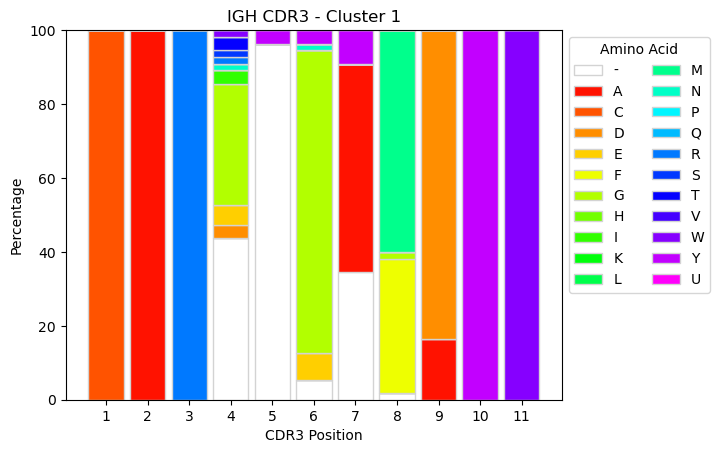

In [191]:
visualize_position_frequency_matrix_cdr3(top_cluster_pp, "IGH CDR3 - Cluster 1")

(14, 22)


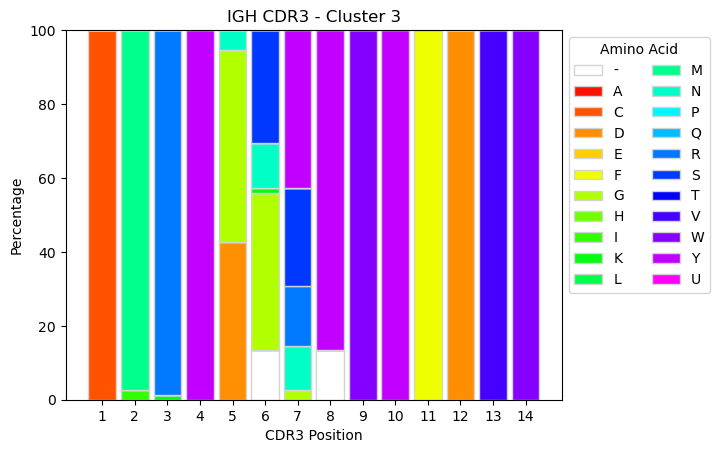

In [192]:
visualize_position_frequency_matrix_cdr3(top_third_cluster_pp, "IGH CDR3 - Cluster 3")

In [197]:
"".join(top_second_cluster_consensus['h_cdr3'][0])

'CARYYKYDYYAMDFW'

In [263]:
consensus_sequence_label = []
consensus_cluster_label = []
consensus_sequences = []

for consensus_idx in range(len(top_cluster_consensus['h_cdr3'])):
    consensus_sequence_label += ['CLUSTER 1, sequence '+str(consensus_idx+1)]
    consensus_sequences += ["".join([aa for aa in top_cluster_consensus['h_cdr3'][consensus_idx] if aa != "-"])]
    
# This is for the one consensus sequence in the second cluster
consensus_sequence_label += ['CLUSTER 2, sequence 1']
consensus_sequences += ["".join(top_second_cluster_consensus['h_cdr3'][0])]
    
#for consensus_idx in range(len(top_second_cluster_consensus['h_cdr3'])):
#    consensus_sequence_label += ['sequence_2.'+str(consensus_idx+1)]
#    consensus_sequences += ["".join([aa for aa in top_second_cluster_consensus['h_cdr3'][consensus_idx] if aa != "-"])]
    
for consensus_idx in range(len(top_third_cluster_consensus['h_cdr3'])):
    consensus_sequence_label += ['CLUSTER 3, sequence '+str(consensus_idx+1)]
    consensus_sequences += ["".join([aa for aa in top_third_cluster_consensus['h_cdr3'][consensus_idx] if aa != "-"])]

# Remove any duplicates within each cluster caused by the removal of variation created by "-"
consensus_df = pd.DataFrame({"sequence_label": consensus_sequence_label, "consensus_sequence": consensus_sequences})
consensus_df['cluster'] = consensus_df['sequence_label'].apply(lambda x: x[8:9])
consensus_df = consensus_df.drop_duplicates(subset=['cluster', 'consensus_sequence'])

consensus_df = consensus_df[['cluster', 'sequence_label', 'consensus_sequence']]

consensus_df

,cluster,sequence_label,consensus_sequence
0,1,"CLUSTER 1, sequence 1",CARGAMDYW
1,1,"CLUSTER 1, sequence 2",CARGAFDYW
2,1,"CLUSTER 1, sequence 3",CARGAGDYW
3,1,"CLUSTER 1, sequence 4",CARGMDYW
4,1,"CLUSTER 1, sequence 5",CARGFDYW
5,1,"CLUSTER 1, sequence 6",CARGGDYW
6,1,"CLUSTER 1, sequence 7",CARGYMDYW
7,1,"CLUSTER 1, sequence 8",CARGYFDYW
8,1,"CLUSTER 1, sequence 9",CARGYGDYW
9,1,"CLUSTER 1, sequence 10",CARGGAMDYW


In [205]:
consensus_df.groupby('cluster_label').count()

,sequence_label,consensus_sequences
cluster_label,,
1,8,8
2,1,1
3,8,8


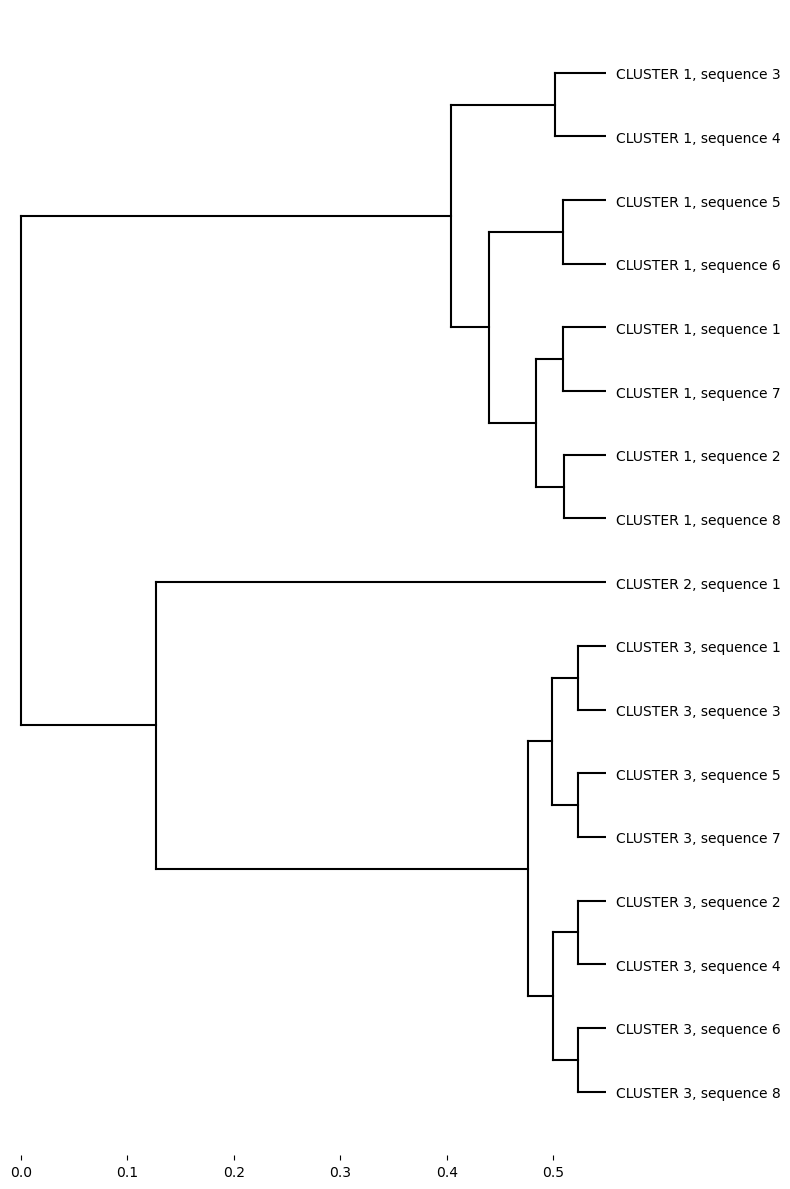

In [201]:
# BLOSUM62 matrix
blosum_matrix = seq.align.SubstitutionMatrix.std_protein_matrix()

alignment, order, tree, distances = seq.align.align_multiple(
    [seq.ProteinSequence(x) for x in consensus_df['consensus_sequences'].to_list()],
    blosum_matrix)

tree = seq.phylo.upgma(distances)

fig = plt.figure(figsize=(8.0, 12.0))
ax = fig.add_subplot(111)

graphics.plot_dendrogram(
    ax, tree, orientation="left", labels=consensus_df['sequence_label'].to_list()
)

fig.tight_layout()

## Compare Generated Consensus Sequences with Established Sequences

In [217]:
established_sequences = pd.read_excel("data/110622_23_ILT2_ILT4_sequences_deom_37_clones_for_expression.xlsx")
established_sequences = established_sequences[['index', 'H-CDR3_aa']].drop_duplicates('H-CDR3_aa')
established_sequences

,index,H-CDR3_aa
0,mAb18,VAYNDYVLFAY
2,mAb20,AYFYYGSSYTMDY
5,mAb23,SNYRYDDYAMDY
6,mAb24,TSNFDY
7,mAb25,GGHGITTIVSFDL
10,mAb28,TNYRYDDYAMDF
11,mAb29,SRAMDY
12,mAb30,SIGTGFAY
13,mAb31,NGYYGRYYALDY
14,mAb32,ADFYDYFAMDS


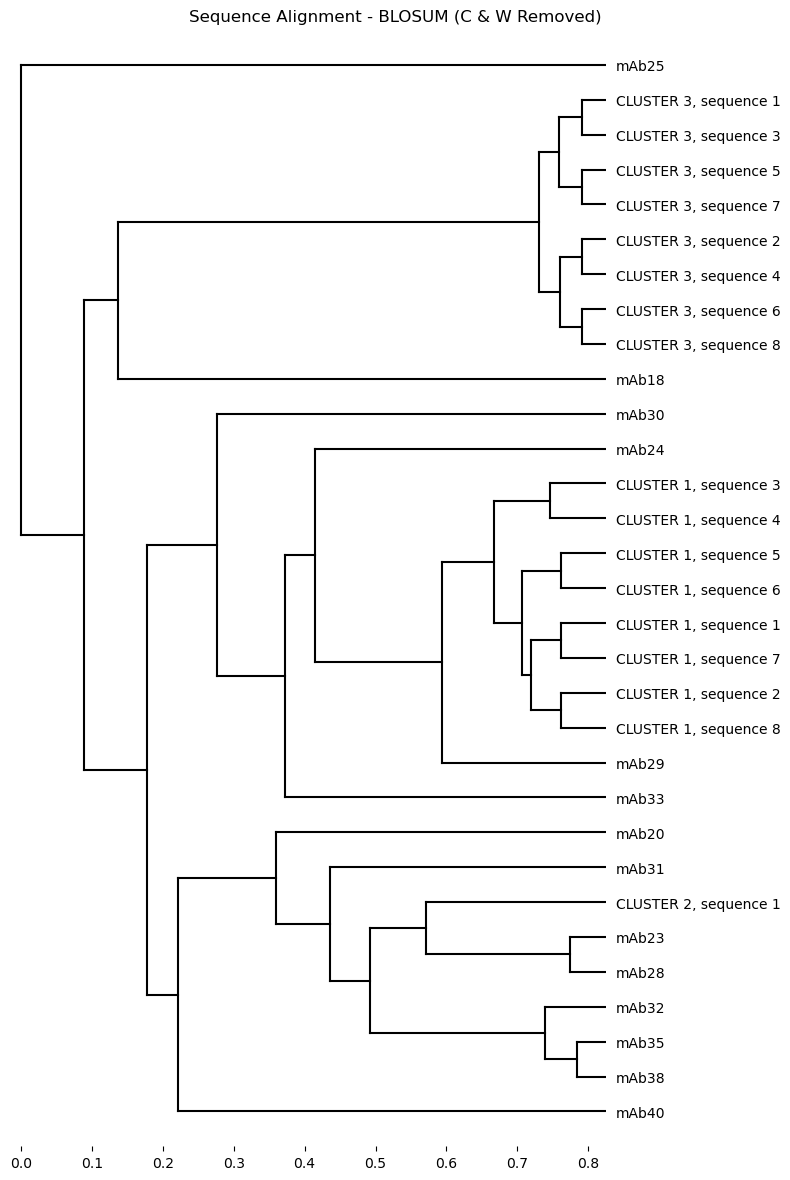

In [218]:
concat_consensus = consensus_df[['sequence_label', 'consensus_sequence']].rename(columns={'sequence_label': 'index', 'consensus_sequence': 'h_cdr3'})

# Strip the C and W at the beginning and the end
concat_consensus['h_cdr3'] = concat_consensus['h_cdr3'].apply(lambda x: x[1:-1])

concat_established = established_sequences[['index', 'H-CDR3_aa']].rename(columns={'H-CDR3_aa': 'h_cdr3'})

consensus_established_seq = pd.concat([concat_consensus, concat_established]).reset_index(drop=True)


alignment, order, tree, distances = seq.align.align_multiple(
    [seq.ProteinSequence(x) for x in consensus_established_seq['h_cdr3'].to_list()], blosum_matrix, gap_penalty=-5)

tree = seq.phylo.upgma(distances)

fig = plt.figure(figsize=(8.0, 12.0))
ax = fig.add_subplot(111)

graphics.plot_dendrogram(
    ax, tree, orientation="left", labels=consensus_established_seq['index'].to_list()
)

plt.suptitle('Sequence Alignment - BLOSUM (C & W Removed)')
fig.tight_layout()

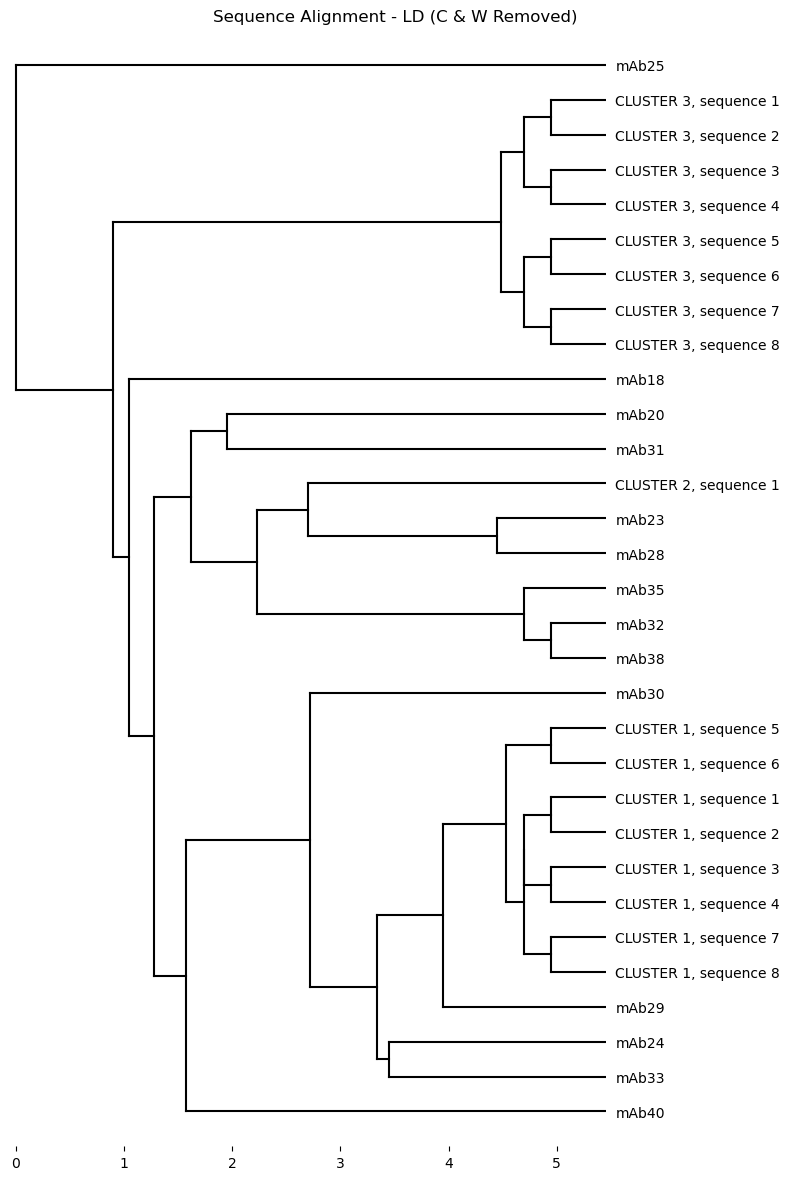

In [219]:
consensus_establish_dist_ld = distance_matrix(consensus_established_seq['h_cdr3'])

tree_ld = seq.phylo.upgma(consensus_establish_dist_ld)

fig = plt.figure(figsize=(8.0, 12.0))
ax = fig.add_subplot(111)

graphics.plot_dendrogram(
    ax, tree_ld, orientation="left", labels=consensus_established_seq['index'].to_list()
)

plt.suptitle('Sequence Alignment - LD (C & W Removed)')
fig.tight_layout()

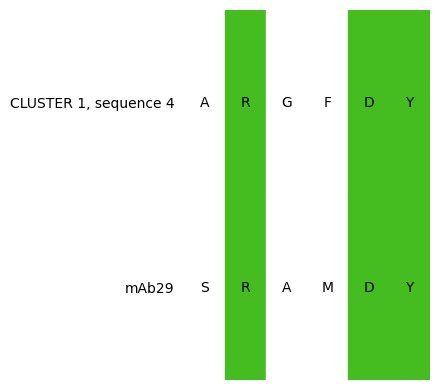

In [227]:
# Compare cluster to nearest hybridoma sequence

# Cluster 1
cluster_hybridoma_pair = ['CLUSTER 1, sequence 4', 'mAb29']
cluster_hybridoma = consensus_established_seq[consensus_established_seq['index'].isin(cluster_hybridoma_pair)]['h_cdr3']
alignment, order, tree, distances = seq.align.align_multiple([seq.ProteinSequence(x) for x in cluster_hybridoma], blosum_matrix)

fig = plt.figure(figsize=(4.5, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=len(alignment),
    labels=cluster_hybridoma_pair
)
fig.tight_layout()

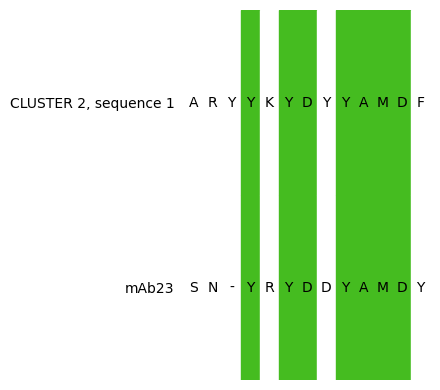

In [228]:
# Cluster 2
cluster_hybridoma_pair = ['CLUSTER 2, sequence 1', 'mAb23']
cluster_hybridoma = consensus_established_seq[consensus_established_seq['index'].isin(cluster_hybridoma_pair)]['h_cdr3']
alignment, order, tree, distances = seq.align.align_multiple([seq.ProteinSequence(x) for x in cluster_hybridoma], blosum_matrix)

fig = plt.figure(figsize=(4.5, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=len(alignment),
    labels=cluster_hybridoma_pair
)
fig.tight_layout()

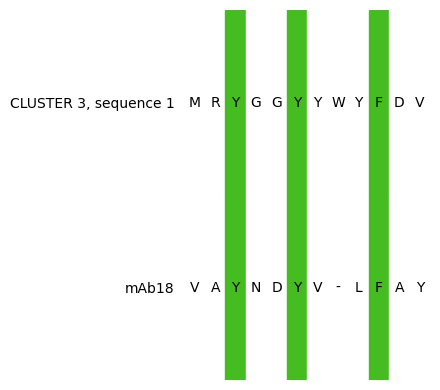

In [230]:
# Cluster 3
cluster_hybridoma_pair = ['CLUSTER 3, sequence 1', 'mAb18']
cluster_hybridoma = consensus_established_seq[consensus_established_seq['index'].isin(cluster_hybridoma_pair)]['h_cdr3']
alignment, order, tree, distances = seq.align.align_multiple([seq.ProteinSequence(x) for x in cluster_hybridoma], blosum_matrix)

fig = plt.figure(figsize=(4.5, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=len(alignment),
    labels=cluster_hybridoma_pair
)
fig.tight_layout()

## Identify Sequence Similar to Hybridoma

Determine whether the 10X sequences have exact or extremely close matches to the hybridoma sequences

In [241]:
# Create all the possible combinations between the hybidoma and 10X sequences and calculate the LD 

# Remove the C and W before calculation
chains_hcdr3_no_cw = chains['h_cdr3'].apply(lambda x: x[1:-1])

hybridoma_vs_chain_ld = pd.DataFrame([list(x) for x in itertools.product(*[established_sequences['H-CDR3_aa'], chains_hcdr3_no_cw])], columns=['hybridoma_seq', 'bcr_seq'])
hybridoma_vs_chain_ld['LD'] = hybridoma_vs_chain_ld.apply(lambda x: lev.distance(x.hybridoma_seq, x.bcr_seq), axis=1)
hybridoma_vs_chain_ld

,hybridoma_seq,bcr_seq,LD
0,VAYNDYVLFAY,ARYYKYDYYAMDF,10
1,VAYNDYVLFAY,AWREPYYYGSRDDY,12
2,VAYNDYVLFAY,AKEGYGNYESAMDY,11
3,VAYNDYVLFAY,ARIRRTEYYAMDY,11
4,VAYNDYVLFAY,AIYYDYAWFAY,5
...,...,...,...
80117,LDTTAPYSMDY,ARSYYRYAFAY,9
80118,LDTTAPYSMDY,ARPIYYYGSSPAWFAY,13
80119,LDTTAPYSMDY,ARESDGYYSWFAY,10
80120,LDTTAPYSMDY,ARDLYDYYFDY,8


In [260]:
# Identify the closely related sequences within the 10X dataset compared to the hybridoma sequences
top_matches_per_hybridoma = pd.DataFrame()

for hybridoma in established_sequences['H-CDR3_aa']:
    # Take the top 5 matches
    top_hits = hybridoma_vs_chain_ld[hybridoma_vs_chain_ld['hybridoma_seq'] == hybridoma].sort_values('LD', ascending=True).head(5)
    
    top_matches_per_hybridoma = pd.concat([top_matches_per_hybridoma, top_hits], axis=0)

# Add the mAb index
top_matches_per_hybridoma = established_sequences.rename(columns={"H-CDR3_aa": "hybridoma_seq"}).set_index('hybridoma_seq').join(top_matches_per_hybridoma.set_index('hybridoma_seq'))

# Reformat the df
top_matches_per_hybridoma = top_matches_per_hybridoma.reset_index()

# Add the cluster info
def cluster_annotation(cell_number):
    for idx in range(len(top10_clusters)):
        if cell_number in top10_clusters[idx]:
            return idx+1
    return None
        
## Add the cell number of the sequence to get the cluster info
cell_number = pd.DataFrame(chains_hcdr3_no_cw).reset_index().set_index('h_cdr3')
cell_number = cell_number.rename(columns={'index': 'cell_number'})
top_matches_per_hybridoma = top_matches_per_hybridoma.set_index("bcr_seq").join(cell_number)

## Annotate with top 10 cluster info
top_matches_per_hybridoma['top_cluster'] = top_matches_per_hybridoma['cell_number'].apply(cluster_annotation)
top_matches_per_hybridoma = top_matches_per_hybridoma.reset_index().rename(columns={"level_0": "bcr_seq"})

top_matches_per_hybridoma = top_matches_per_hybridoma[['index', 'hybridoma_seq', 'bcr_seq', 'cell_number', 'LD', 'top_cluster']]
top_matches_per_hybridoma = top_matches_per_hybridoma.sort_values("LD", ascending=True)

top_matches_per_hybridoma

,index,hybridoma_seq,bcr_seq,cell_number,LD,top_cluster
151,mAb29,SRAMDY,VRAMDY,9245,1,NaN
149,mAb24,TSNFDY,TSFDY,16750,1,NaN
133,mAb33,GEDY,TGYDY,7793,2,NaN
132,mAb33,GEDY,TGYDY,7490,2,NaN
131,mAb33,GEDY,TGYDY,7474,2,NaN
...,...,...,...,...,...,...
29,mAb25,GGHGITTIVSFDL,ARGITTVFDY,13148,6,NaN
30,mAb25,GGHGITTIVSFDL,ARGITTVFDY,4592,6,NaN
31,mAb25,GGHGITTIVSFDL,ARGITTVFDY,13148,6,NaN
43,mAb25,GGHGITTIVSFDL,ARQGITTVVYFDY,12411,6,NaN


In [261]:
9245 in top10_clusters[0]

False

In [47]:
top_matches_per_hybridoma.to_excel("code/10X_bcr_vdj_example/ILT4/set1_10062022/set1_10062022_ILT4_hybridoma_matches.xlsx", index=None)

In [252]:
# Filter out the ones with low LD
top_matches_per_hybridoma_filtered = top_matches_per_hybridoma[top_matches_per_hybridoma['LD'] < 3].sort_values("LD")
top_matches_per_hybridoma_filtered

,index,hybridoma_seq,bcr_seq,LD,top_cluster
151,mAb29,SRAMDY,VRAMDY,1,NaN
149,mAb24,TSNFDY,TSFDY,1,NaN
25,mAb29,SRAMDY,ARGAMDY,2,NaN
147,mAb24,TSNFDY,TRGFDY,2,NaN
5,mAb29,SRAMDY,ARDMDY,2,NaN
26,mAb29,SRAMDY,ARGAMDY,2,NaN
6,mAb29,SRAMDY,ARDMDY,2,NaN
142,mAb24,TSNFDY,TIFDY,2,NaN
141,mAb24,TSNFDY,TIFDY,2,NaN
139,mAb33,GEDY,TGYDY,2,NaN


In [257]:
top_matches_per_hybridoma.groupby("LD").count()

,index,hybridoma_seq,bcr_seq,top_cluster
LD,,,,
1,2,2,2,0
2,49,49,49,0
3,44,44,44,0
4,34,34,34,1
5,16,16,16,0
6,7,7,7,0


In [256]:
top_matches_per_hybridoma.groupby('index').mean().sort_values("LD")[["LD"]].rename(columns={"LD": "Average LD per Top 5 Hits"})

,Average LD per Top 5 Hits
index,
mAb24,1.833333
mAb29,1.950000
mAb33,2.000000
mAb30,2.500000
mAb23,3.000000
mAb35,3.000000
mAb38,3.000000
mAb20,3.285714
mAb28,4.000000
